[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neurobiology-ut/Philis/blob/feature/add_train_and_pred_notebooks/notebooks/train.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam , RMSprop
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , CSVLogger
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

from tqdm.notebook import tqdm
import zipfile

In [2]:
def normalize_x(image):
    return image / 127.5 - 1


def normalize_y(image):
    return image / 255


def denormalize_y(image):
    return image * 255

In [3]:
def load_X_gray(folder_path):
    
    image_files = []       
    for file in os.listdir(folder_path):
        base, ext = os.path.splitext(file)
        if ext == '.png':
            image_files.append(file)
        else :
            pass
        
    image_files.sort()
    
    img = cv2.imread(folder_path + os.sep + image_files[0], cv2.IMREAD_GRAYSCALE)
    
    images = np.zeros((len(image_files), img.shape[0], img.shape[1], 1), np.float32)
    for i, image_file in tqdm(enumerate(image_files)):
        image = cv2.imread(folder_path + os.sep + image_file, cv2.IMREAD_GRAYSCALE)
        image = image[:, :, np.newaxis]
        images[i] = normalize_x(image)
    
    print(images.shape)
    
    return images, image_files


def load_Y_gray(folder_path, thresh = None , normalize = False):
    
    image_files = []
    for file in os.listdir(folder_path):
        base, ext = os.path.splitext(file)
        if ext == '.png':
            image_files.append(file)
        else:
            pass
        
    image_files.sort()
    
    img = cv2.imread(folder_path + os.sep + image_files[0], cv2.IMREAD_GRAYSCALE)
    
    images = np.zeros((len(image_files), img.shape[0], img.shape[1], 1) ,np.float32)
    
    for i , image_file in tqdm(enumerate(image_files)):
        image = cv2.imread(folder_path + os.sep + image_file, cv2.IMREAD_GRAYSCALE)
        if thresh:
            ret , image = cv2.threshold(image , thresh , 255 , cv2.THRESH_BINARY)
        image = image[:, :, np.newaxis]
        if normalize:
            images[i] = normalize_y(image)
        else:
            images[i] = image
            
    print(images.shape)
    
    return images, image_files

In [4]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


def weighted_dice_coeff(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    return score


def weighted_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    if K.int_shape(y_pred)[1] == 128:
        kernel_size = 11
    elif K.int_shape(y_pred)[1] == 256:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 512:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 1024:
        kernel_size = 41
    else:
        raise ValueError('Unexpected image size')
    averaged_mask = K.pool2d(
        y_true, pool_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 1 - weighted_dice_coeff(y_true, y_pred, weight)
    return loss


def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))

    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
                                          (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)


def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    if K.int_shape(y_pred)[1] == 128:
        kernel_size = 11
    elif K.int_shape(y_pred)[1] == 256:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 512:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 1024:
        kernel_size = 41
    else:
        raise ValueError('Unexpected image size')
    averaged_mask = K.pool2d(
        y_true, pool_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + (1 - weighted_dice_coeff(y_true, y_pred, weight))
    return loss

In [5]:
def standard_uint(input_tensor, nb_filter):
    
    x = Conv2D(nb_filter, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_nested_unet(input_shape=(512, 512, 1), num_classes=3, deep_supervision = False):
    
    with tf.device('/gpu:0'):
        
        inputs = Input(shape = input_shape)
        
        # 512
        conv1_1 = standard_uint(inputs, nb_filter = 16)
        pool1 = MaxPooling2D((2, 2), strides = (2, 2))(conv1_1)
        
        #256
        conv2_1 = standard_uint(pool1, nb_filter = 32)
        pool2 = MaxPooling2D((2, 2), strides = (2, 2))(conv2_1)
        
        up1_2 = Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same')(conv2_1)
        conv1_2 = concatenate([up1_2, conv1_1], axis = 3)
        conv1_2 = standard_uint(conv1_2, nb_filter = 16)
        
        #128
        conv3_1 = standard_uint(pool2, nb_filter = 64)
        pool3 = MaxPooling2D((2, 2), strides = (2, 2))(conv3_1)
        
        up2_2 = Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(conv3_1)
        conv2_2 = concatenate([up2_2, conv2_1], axis = 3)
        conv2_2 = standard_uint(conv2_2, nb_filter = 32)
        
        up1_3 = Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same')(conv2_2)
        conv1_3 = concatenate([up1_3, conv1_1, conv1_2], axis = 3)
        conv1_3 = standard_uint(conv1_3, nb_filter = 16)
        
        # 64
        conv4_1 = standard_uint(pool3, nb_filter = 128)
        pool4 = MaxPooling2D((2, 2), strides = (2, 2))(conv4_1)      
        
        up3_2 = Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(conv4_1)
        conv3_2 = concatenate([up3_2, conv3_1], axis = 3)
        conv3_2 = standard_uint(conv3_2, nb_filter = 64)    
        
        up2_3 = Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(conv3_2)
        conv2_3 = concatenate([up2_3, conv2_1, conv2_2], axis = 3)
        conv2_3 = standard_uint(conv2_3, nb_filter = 32)        
        
        up1_4 = Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same')(conv2_3)
        conv1_4 = concatenate([up1_4, conv1_2, conv1_3], axis = 3)
        conv1_4 = standard_uint(conv1_4, nb_filter = 16)       
        
        # 32
        conv5_1 = standard_uint(pool4, nb_filter = 256)    
        
        up4_2 = Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(conv5_1)
        conv4_2 = concatenate([up4_2, conv4_1], axis = 3)
        conv4_2 = standard_uint(conv4_2, nb_filter = 128)  
        
        up3_3 = Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(conv4_2)
        conv3_3 = concatenate([up3_3, conv3_1, conv3_2], axis = 3)
        conv3_3 = standard_uint(conv3_3, nb_filter = 64)
        
        up2_4 = Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(conv3_3)
        conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], axis = 3)
        conv2_4 = standard_uint(conv2_4, nb_filter = 32)
        
        up1_5 = Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same')(conv2_4)
        conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], axis = 3)
        conv1_5 = standard_uint(conv1_5, nb_filter = 16)
        
        nested_output_1 = Conv2D(num_classes, (1, 1), activation = 'sigmoid')(conv1_2)
        nested_output_2 = Conv2D(num_classes, (1, 1), activation = 'sigmoid')(conv1_3)
        nested_output_3 = Conv2D(num_classes, (1, 1), activation = 'sigmoid')(conv1_4)
        nested_output_4 = Conv2D(num_classes, (1, 1), activation = 'sigmoid')(conv1_5)
        
        if deep_supervision:
            model = Model(inputs = inputs, outputs = [nested_output_1, nested_output_2, nested_output_3, nested_output_4]) 
        else:
            model = Model(inputs = inputs, outputs = [nested_output_4])
            
        model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])
        
        return model

In [10]:
def train_unet(X_train,Y_train, csv_path, model_path ,input_shape=(512, 512, 1), num_classes=1):
    Y_train = Y_train
    X_train = X_train

    data_gen_args = dict(
        rotation_range=90.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    # Provide the same seed and keyword arguments to the fit and flow methods
    seed = 1
    image_datagen.fit(X_train, augment=True, seed=seed)
    mask_datagen.fit(Y_train, augment=True, seed=seed)

    image_generator = image_datagen.flow(X_train, seed=seed, batch_size=8)
    mask_generator = mask_datagen.flow(Y_train, seed=seed, batch_size=8)

    # combine generators into one which yields image and masks
    train_generator = (pair for pair in zip(image_generator, mask_generator))

    model = get_nested_unet(input_shape=input_shape, num_classes=num_classes)

    BATCH_SIZE = 4
    NUM_EPOCH = 40
    
    callbacks = []
    from tensorflow.keras.callbacks import CSVLogger
    callbacks.append(CSVLogger(csv_path))
    history = model.fit_generator(train_generator,steps_per_epoch=32, epochs=NUM_EPOCH, verbose=1, callbacks=callbacks)
    model.save_weights(model_path)

In [19]:
def predict(X_test, model_path, out_dir, input_shape=(512, 512, 1), num_classes=1):

    model = get_nested_unet(input_shape=input_shape, num_classes=num_classes)
    
    model.load_weights(model_path)
    BATCH_SIZE = 1
    Y_pred = model.predict(X_test, BATCH_SIZE)
    
    print(Y_pred.shape)
    os.makedirs(out_dir, exist_ok = True)
    
    if Y_pred.shape[3]!=1:
        num = Y_pred.shape[3]
        for n in range(num):
            os.makedirs(os.path.join(out_dir,str(n+1)), exist_ok=True)
        for i, y in enumerate(Y_pred):
            for n in range(num):
                cv2.imwrite(os.path.join(out_dir, str(n+1) , str(i).zfill(6) + '.png'), denormalize_y(y[:,:,n]))
        
    else:
        for i, y in enumerate(Y_pred):
            cv2.imwrite(os.path.join(out_dir , str(i).zfill(6) + '.png'), denormalize_y(y))

In [27]:
def make_mask_img(ori_img, mask_img):
    mask_img_rgb = np.zeros((mask_img.shape[0], mask_img.shape[1], 3), np.float32)
    mask_img_rgb[:,:,0] = mask_img[:,:,0]
    mask_img_rgb[:,:,2] = mask_img[:,:,0]
    masked_img = cv2.addWeighted(mask_img_rgb,0.5,cv2.cvtColor(ori_img+0.75, cv2.COLOR_GRAY2BGR),0.6,0)
    return masked_img

# train

In [7]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1aDRFDsdWA__N0_bGUZcZaStsPRmJRmgr',
                                    dest_path='./train/label.zip',
                                    unzip=True)

Unzipping...Done.


In [8]:
gdd.download_file_from_google_drive(file_id='1fKNJgyZuJMz6-r9LaqfN_9SDUp1ig-lL',
                                    dest_path='./train/ori.zip',
                                    unzip=True)

Unzipping...Done.


In [9]:
ori_imgs , _ = load_X_gray('./train/ori')
label_imgs , _ = load_Y_gray('./train/label', normalize=True)



(10, 512, 512, 1)



(10, 512, 512, 1)


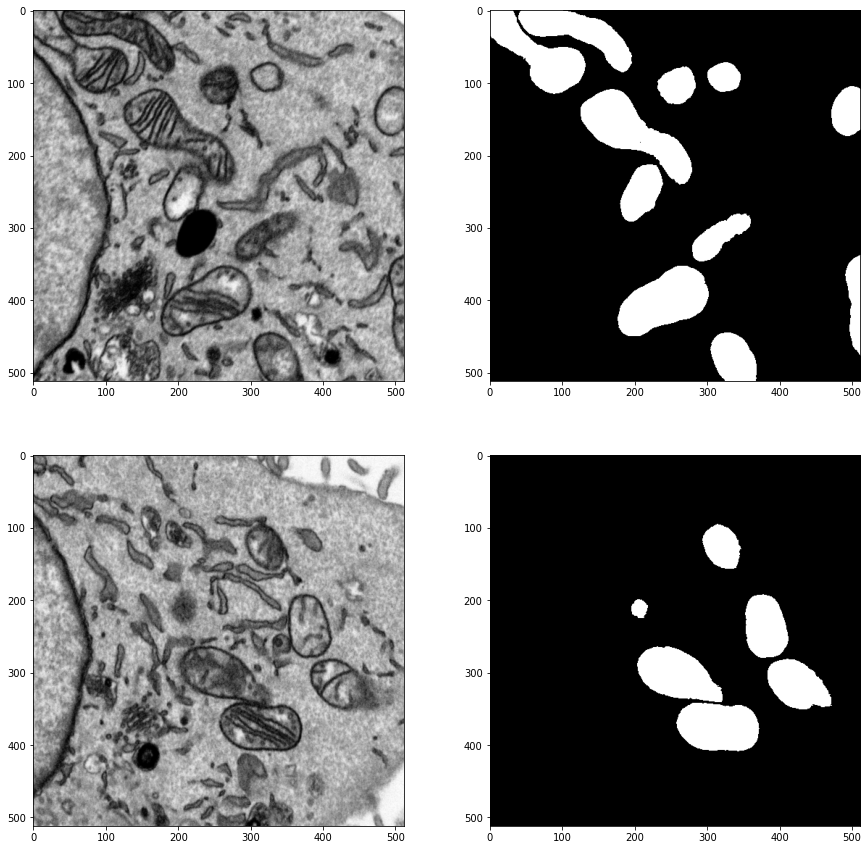

In [11]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.imshow(ori_imgs[4][:,:,0], "gray")

plt.subplot(2, 2, 2)
plt.imshow(label_imgs[4][:,:,0], "gray")

plt.subplot(2, 2, 3)
plt.imshow(ori_imgs[7][:,:,0], "gray")

plt.subplot(2, 2, 4)
plt.imshow(label_imgs[7][:,:,0], "gray")

In [12]:
train_unet(
    X_train = ori_imgs,
    Y_train = label_imgs, 
    csv_path = "train_log.csv", 
    model_path = "demo.hdf5", 
    input_shape = (512, 512, 1),
    num_classes = 1
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
32/32 [==============================] - 54s 425ms/step - loss: 1.1966 - dice_coeff: 0.3541
Epoch 2/40
32/32 [==============================] - 13s 388ms/step - loss: 0.9095 - dice_coeff: 0.4507
Epoch 3/40
32/32 [==============================] - 13s 388ms/step - loss: 0.8164 - dice_coeff: 0.4874
Epoch 4/40
32/32 [==============================] - 13s 386ms/step - loss: 0.7381 - dice_coeff: 0.5455
Epoch 5/40
32/32 [==============================] - 13s 386ms/step - loss: 0.6909 - dice_coeff: 0.5473
Epoch 6/40
32/32 [==============================] - 13s 385ms/step - loss: 0.6748 - dice_coeff: 0.5657
Epoch 7/40
32/32 [==============================] - 13s 387ms/step - loss: 0.6489 - dice_coeff: 0.5796
Epoch 8/40
32/32 [==============================] - 13s 388ms/step - loss: 0.6236 - dice_coeff: 0.5806
Epoch 9/40
32/32 [==============================] - 13s 385ms/step - loss: 0.6079 - dice_coeff: 0.5997
Epoch 10/40
32/32 [==============================] - 13s 385ms/step - los

# predict

In [14]:
gdd.download_file_from_google_drive(file_id='17Vr2-ZfKs0mbGcsLybd1qUgHxuEaBM1b',
                                    dest_path='./test/ori.zip',
                                    unzip=True)

Unzipping...Done.


In [16]:
test_imgs , _ = load_X_gray('./test/test/ori')


(200, 512, 512, 1)


In [20]:
predict(
    X_test = test_imgs, 
    model_path = "demo.hdf5", 
    out_dir = "./pred", 
    input_shape = (512, 512, 1), 
    num_classes = 1
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(200, 512, 512, 1)


# confirm

In [25]:
pred_imgs,_ = load_Y_gray("./pred", thresh=127)


(200, 512, 512, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


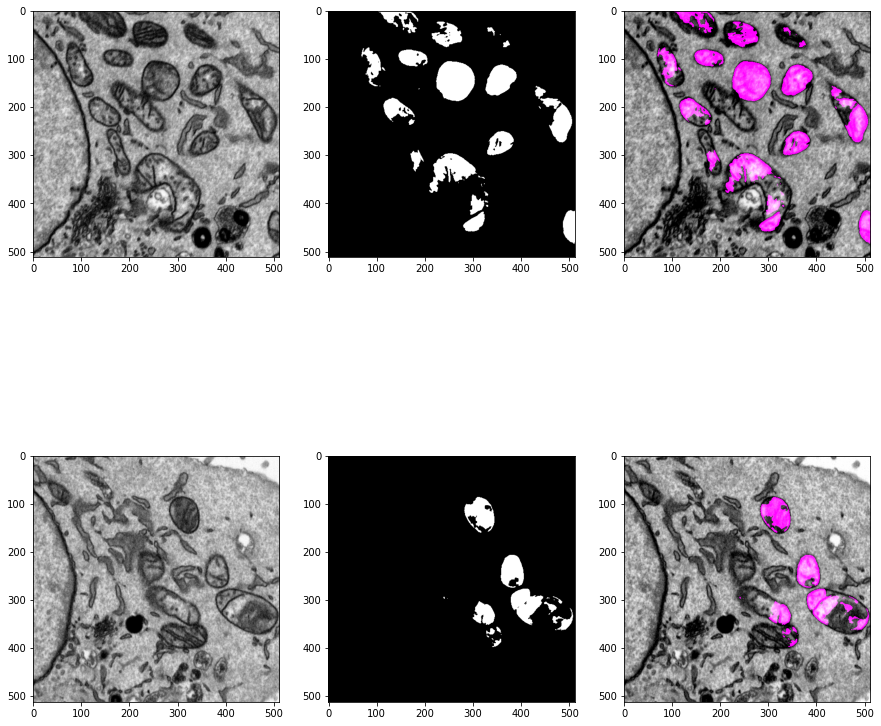

In [30]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 3, 1)
plt.imshow(test_imgs[25][:,:,0], "gray")

plt.subplot(2, 3, 2)
plt.imshow(pred_imgs[25][:,:,0], "gray")

plt.subplot(2, 3, 3)
plt.imshow(make_mask_img(test_imgs[25], pred_imgs[25]))

plt.subplot(2, 3, 4)
plt.imshow(test_imgs[125][:,:,0], "gray")

plt.subplot(2, 3, 5)
plt.imshow(pred_imgs[125][:,:,0], "gray")

plt.subplot(2, 3, 6)
plt.imshow(make_mask_img(test_imgs[125], pred_imgs[125]))